In [ ]:
# En caso de problemas, utilizar las dependencias de librerías de este requierement: https://github.com/googlecolab/backend-info/blob/d6d345cb94fc5fd49951c9af0f6ead5e962bfab2/pip-freeze.txt
!pip install numpy==1.23.5
!pip install transformers[torch]==4.35.2
!pip install accelerate -U
!pip install evaluate

In [ ]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

**En este ejercicio debeis entrenar un modelo de clasificación utilizando la librería Transformers.** Dado que el análisis exploratorio ha sido realizado en el ejercicio anterior, en este caso podréis centraros en entrenar el modelo utilizando la librería Transformers, seleccionando un modelo pre-entrenado adecuado, entrenando el modelo y llevando a cabo la evaluación.


**Nota 1**: Este ejercicio requiere el uso de las GPUs de Google Colab. Este Colab debería estar preconfigurado para ejecutarse en GPU, pero si tuviera problemas en la ejecución que me contacte a través del Moodle para buscar soluciones alternativas.

## 0. Imports


In [ ]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   AutoModelForSequenceClassification,
   AdamW
)
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [ ]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [ ]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

Podéis saltarlo en este ejercicio.

## 3. Preprocesado y Normalización

Dividimos el dataset para el proceso. Separamos en 2 varibales distintas los textos y etiquetas.

In [ ]:
texts = dataset.tweet_text.values  # an array of strings
labels = dataset.cyberbullying.values  # an array of integers

## 4. Vectorización

Dividimos a su vez, el dataset en training, validatio y test ya que en el caso de las redes neuronales es necesario que haya una parte de validación:

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=.25,
                                                                      random_state=0,stratify = labels)

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2,
                                                                    random_state=0,stratify = train_labels)

Definimos el modelo que vamos a utilizar. En este caso utilizaremos el modelo Bert basico por tener un tamaño considerable para los recursos que tenemos:

In [ ]:
model_name = 'bert-base-uncased'

Aplicamos el tokenizador del propio modelo:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Constructor de la clase CustomDataset.
        Parámetros:
        - texts: Lista de textos.
        - labels: Lista de etiquetas correspondientes a los textos.
        - tokenizer: Objeto del tokenizador a utilizar.
        - max_length: Longitud máxima de la secuencia después de la tokenización.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Devuelve la longitud del conjunto de datos.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Obtiene un elemento del conjunto de datos.

        Parámetros:
        - idx: Índice del elemento a obtener.

        Devuelve:
        Un diccionario con 'input_ids', 'attention_mask' y 'labels'.
        """
        # Obtener el texto y la etiqueta del índice proporcionado
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenizar el texto
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        # Devolver el diccionario con los datos
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Se genera 3 datasets nuevos transformados con la función anterior para cada una de las divisiones que hemos realizado previamente más arriba. Ajustamos la longuitud de los vectores, debido a que son tweets y no son muy largos inidcmaos 128 debido a que por defecto son más de 700 y vemos que es excesivamente grande:

In [ ]:
max_length = 128  # Puedes ajustar esto según tus necesidades

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)


Ajustamos también los tramos en los que va a ir consumiendo los documentos la red neuronal. No ponemos más de 8 como tamaño ya que los recursos que tenemos son limitados y pueden dar problemas indicar más:

In [ ]:
max_seq_length = 96 #@param {type: "integer"}
train_batch_size =  8#@param {type: "integer"}
eval_batch_size = 8 #@param {type: "integer"}
test_batch_size = 8 #@param {type: "integer"}

## 5. Entrenamiento y evaluación de modelos


Definimos el mmodelo de clasificación a utilizar dentro del que ya seleccionamos anteriormente:

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "NO_cyberbullying", 1: "cyberbullying"}
label2id = {"NO_cyberbullying": 0, "cyberbullying": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=2, id2label=id2label, label2id=label2id)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Ajustamos los parametros de entrenamiento. Modificamos las epocas a 1 ya que se ha intentaod con 4 pero debido a que estamos utilizando collab, se supera la capacidad de computo limitada diaria y no termina. Sin embargo, el resultado que se muestra sin correr el codigo está ejecutado con 4 ya que si nos lo dejó hacer una de las veces.

In [ ]:
import accelerate

training_args = TrainingArguments(
    output_dir="modelo_test",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)

In [ ]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_score_value = f1_score.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy_value,
        "f1_score": f1_score_value,
    }

Definimos parametos de entrenamiento:

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Realizamos el entrenamiento de nuestra red. (Aparecen 4 epocas pero en el codigo de arriba se ha cambiado el valor a 1 porque se ha agotado la potencia de la gpu de collab)

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.262800,0.248800,{'accuracy': 0.8916689963656695},{'f1': 0.9361561907900156}
2,0.240700,0.271012,{'accuracy': 0.8957226726306962},{'f1': 0.9393791646351374}


Trainer is attempting to log a value of "{'accuracy': 0.8916689963656695}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9361561907900156}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8957226726306962}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9393791646351374}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.262800,0.248800,{'accuracy': 0.8916689963656695},{'f1': 0.9361561907900156}
2,0.240700,0.271012,{'accuracy': 0.8957226726306962},{'f1': 0.9393791646351374}
3,0.200200,0.417095,{'accuracy': 0.885937936818563},{'f1': 0.9332242225859247}
4,0.154000,0.529028,{'accuracy': 0.8846798993570031},{'f1': 0.9320596228279667}


Trainer is attempting to log a value of "{'accuracy': 0.885937936818563}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9332242225859247}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8846798993570031}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9320596228279667}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=14308, training_loss=0.21792924394146304, metrics={'train_runtime': 3130.6901, 'train_samples_per_second': 36.561, 'train_steps_per_second': 4.57, 'total_flos': 7528922849126400.0, 'train_loss': 0.21792924394146304, 'epoch': 4.0})

## evaluacion

Realizamos la evaluación y la predicción sobre los datos de test.

In [ ]:
# Se evalua a priori sobre los datos de test
trainer.evaluate(test_dataset)

Trainer is attempting to log a value of "{'accuracy': 0.8876121781430848}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9337551908245996}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.2591255307197571,
 'eval_accuracy': {'accuracy': 0.8876121781430848},
 'eval_f1_score': {'f1': 0.9337551908245996},
 'eval_runtime': 89.5917,
 'eval_samples_per_second': 133.082,
 'eval_steps_per_second': 16.642,
 'epoch': 4.0}

In [ ]:
# Se hace la predicción sobre los datos de test
predictions = trainer.predict(test_dataset)

In [ ]:
#Ejemplo de una de las predicciones
predictions[0][0]

array([-2.1744998,  2.0953395], dtype=float32)

Escogemos la probabilidad más alta del resultado anterior ya que al final ese será la clasificación que ha predicho nuestro modelo:

In [ ]:
# Access the predicted labels
y_pred = predictions.predictions.argmax(axis=1)

Generamos un dataset con las soluciones de test unicmaente:

In [ ]:
y_true = [x["labels"].item() for x in test_dataset]

Con todo lo realizado anteriormente sacamos las metricas y matriz de confusión:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[1139  847]
 [ 493 9444]]
              precision    recall  f1-score   support

           0       0.70      0.57      0.63      1986
           1       0.92      0.95      0.93      9937

    accuracy                           0.89     11923
   macro avg       0.81      0.76      0.78     11923
weighted avg       0.88      0.89      0.88     11923



### Conclusiones finales y comparación con ingenieria de caracteristicas

Como se puede ver en las metricas de la red neuronal los resultado en general son mejores. No hay una diferencia abismal pero si suficiente y considerable. Eso sí, en la red neuronal se pierde toda la explicabilidad y conocimiento de los datos y de la importancia de las varibales para que el modelo se decante por decir si pertence un tweet a la clase 1 o 0.

Además, con ingenieria de caracteristicas las características diseñadas específicamente pueden adaptarse mejor a un problema particular y pueden ser más interpretables. Sin embargo, Las redes neuronales capturan automáticamente patrones complejos en los datos sin necesidad de especificar manualmente las características. Esto puede ser útil cuando las relaciones entre las características y las salidas son difíciles de definir o están altamente interconectadas, además de ser más "sencillo y/o rapido" en su ejecución. Pueden ser más utiles si se quiere realziar proyectos de forma rapida y son más faciles de escalar en los casos en los que los datos son masivos.

También destacar que la capacidad de computación para entrenar redes neuronales es mucho mayor y es necesario tener GPU para poder realziarlo más rapidamente.

En cuanto a la clase 0 mejora ligeramente (f1-score solo 0.01 mejor que mediante ingenieria de caract.). Y en la clase 1 los sigue detectando muy bien pero con un mayor recall, ahí donde se aprecia la diferencia y la mejora del modelo. Si se balancean los datos para la red neuronal posiblemente mejoren las metricas para la clase 0.

Comparando las matrices de confusión se ve claramente que se equivoca mucho menos que con ingenieria de caracteristicas por lo que si el objetivo es simplemente predecir bien sin importar la explicabilidad de las respuestas del modelo se debe elegir realizar un modelo mediante redes neuronales. No obstante, Si se prefiere esa explicabilidad y conocimiento sobre los datos y tener mayor adaptabilidad se debe optar por un modelo mediante ingenieria de caracteristicas.


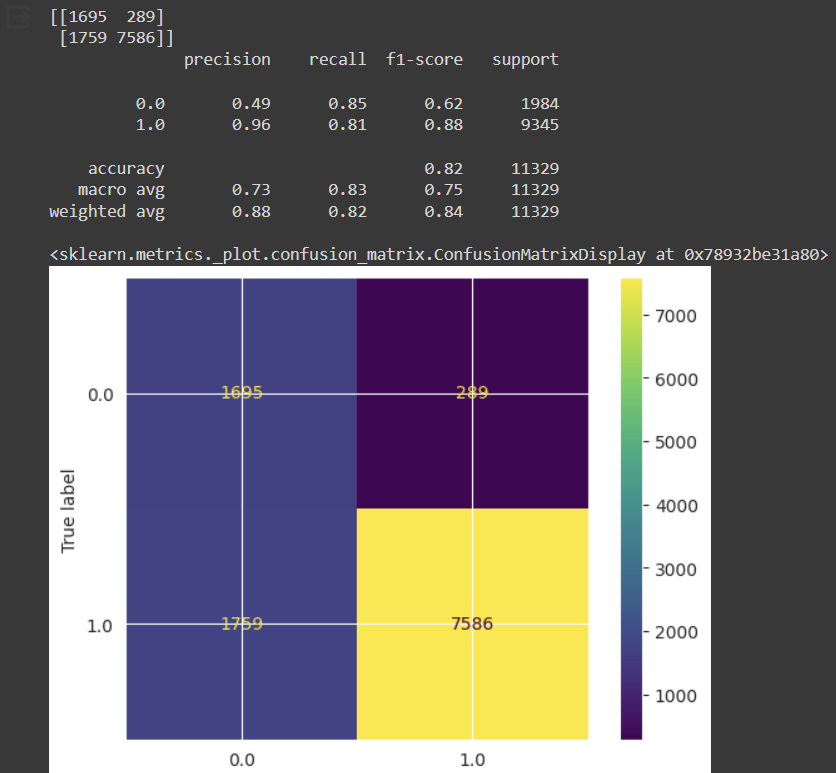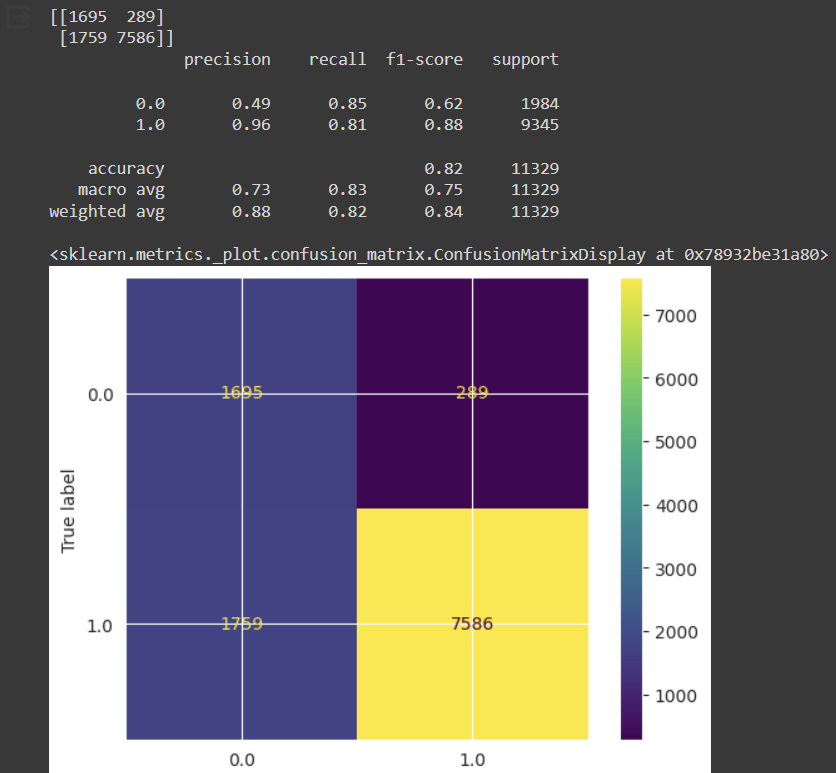![image.png](
)